In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from paretoset import paretoset

version = 6
file_name = "syn_2"
attribute_key = "property_lt_20"

case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

In [2]:
log = pm4py.read_xes(f'logs/{file_name}.xes')

/home/lennc/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 100/100 [00:00<00:00, 6857.70it/s]


In [3]:
pm4py.stats.get_trace_attributes(log)

['case:concept:name', 'case:property_lt_20']

In [4]:
df = pm4py.convert_to_dataframe(log)
df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [5]:
def uEMSC(l, m):
    return 1 - sum([ max(pr - (m.get(tr) or 0), 0) for tr, pr in l.items() if pr > 0 ])

In [6]:
def Gini(l, m):
    n1 = len(l)
    n2 = len(m)
    n = n1 + n2
    return (n1/n) * (1 - sum([ pr**2 for pr in l.values() ])) + (n2/n) * (1 - sum([ pr**2 for pr in m.values() ]))

In [7]:
case_attribute_key = f'case:{attribute_key}'

attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

lt_sizes = [0]
gte_sizes = [len(grouped.first().index)]

uemscs = []

ginis = []
g1s = []
g2s = []
n1s = []
n2s = []

for idx, pivot in enumerate(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light = df_gte_light[df_gte_light[case_attribute_key] < pivot]

    # remove affected cases from gte group
    df_gte_light = df_gte_light.drop(df_affected_light.index)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light.index ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    stochastic_language_lt = { k: v / language_lt_size for k, v in language_lt.items() }
    stochastic_language_gte = { k: v / language_gte_size for k, v in language_gte.items() }

    uemsc = uEMSC(stochastic_language_lt, stochastic_language_gte)

    n1 = language_lt_size
    n2 = language_gte_size
    n = n1 + n2
    g1 = (1 - sum([ pr**2 for pr in stochastic_language_lt.values() ])) 
    g2 = (1 - sum([ pr**2 for pr in stochastic_language_gte.values() ]))
    gini = (n1/n) * g1 + (n2/n) * g2

    print(f'[{idx}/{len(attribute_values) - 1}]: (uEMSC) {uemsc} | (Gini) {gini}')
    
    # collect data to plot graph
    uemscs.append(uemsc)
    ginis.append(gini)
    n1s.append(n1/n)
    n2s.append(n2/n)
    g1s.append(g1)
    g2s.append(g2)
    lt_sizes.append(language_lt_size)
    gte_sizes.append(language_gte_size)

[0/64]: (uEMSC) 0.0 | (Gini) 0.9795918367346939
[1/64]: (uEMSC) 0.0 | (Gini) 0.9795833333333334
[2/64]: (uEMSC) 0.010752688172043223 | (Gini) 0.9797849462365592
[3/64]: (uEMSC) 0.010869565217391353 | (Gini) 0.9797826086956523
[4/64]: (uEMSC) 0.011111111111111183 | (Gini) 0.9797777777777777
[5/64]: (uEMSC) 0.011363636363636243 | (Gini) 0.9797727272727274
[6/64]: (uEMSC) 0.011494252873563537 | (Gini) 0.9797701149425287
[7/64]: (uEMSC) 0.011764705882353121 | (Gini) 0.979764705882353
[8/64]: (uEMSC) 0.0 | (Gini) 0.9785119047619046
[9/64]: (uEMSC) 0.0 | (Gini) 0.9785825655563429
[10/64]: (uEMSC) -2.220446049250313e-16 | (Gini) 0.9786449864498644
[11/64]: (uEMSC) -2.220446049250313e-16 | (Gini) 0.97875
[12/64]: (uEMSC) -4.440892098500626e-16 | (Gini) 0.978794454490657
[13/64]: (uEMSC) 3.3306690738754696e-16 | (Gini) 0.9788344988344988
[14/64]: (uEMSC) 4.440892098500626e-16 | (Gini) 0.9788706945228686
[15/64]: (uEMSC) 4.440892098500626e-16 | (Gini) 0.9789035087719298
[16/64]: (uEMSC) 0.013333

In [8]:
# total number of traces
total = len(grouped.first().index)

# compute relative frequency of traces with certain attribute values
abs_freq = grouped.first().assign(n=1).groupby([case_attribute_key]).count()["n"].tolist() # get number of traces traces with same attribute value
rel_freq = [ v / total for v in abs_freq ]

# convert language sizes to relative sizes
rel_lt_sizes = [ s / total for s in lt_sizes ]
rel_gte_sizes = [ s / total for s in gte_sizes ]

In [9]:
# get 10% & 90% marks

alpha = 0.1

bounds_idx = {
    "lower": None, "upper": None
}

target = alpha * total
seen = 0
for (i, freq) in enumerate(abs_freq):
    seen += freq
    if seen >= target:
        bounds_idx["lower"] = i + 1
        break

target = alpha * total
seen = 0
for (i, freq) in reversed(list(enumerate(abs_freq))):
    seen += freq
    if seen >= target:
        bounds_idx["upper"] = i - 1
        break

bounds_idx

{'lower': 5, 'upper': 57}

In [10]:
# sanity check
s = 0
for x in rel_freq[bounds_idx["lower"]:bounds_idx["upper"]]:
    s += x

print(f'% traces in {alpha * 100}-{(1-alpha) * 100} range: {s}')

print(f'rel_lt_sizes at {alpha * 100}% mark: {rel_lt_sizes[bounds_idx["lower"] - 1]} / {rel_lt_sizes[bounds_idx["lower"]]}')
print(f'rel_lt_sizes at {(1 - alpha) * 100}% mark: {rel_lt_sizes[bounds_idx["upper"] - 1]} / {rel_lt_sizes[bounds_idx["upper"]]}')
print(f'rel_gte_sizes at {alpha * 100}% mark: {rel_gte_sizes[bounds_idx["lower"] - 1]} / {rel_gte_sizes[bounds_idx["lower"]]}')
print(f'rel_gte_sizes at {(1 - alpha) * 100}% mark: {rel_gte_sizes[bounds_idx["upper"] - 1]} / {rel_gte_sizes[bounds_idx["upper"]]}')

% traces in 10.0-90.0 range: 0.7900000000000004
rel_lt_sizes at 10.0% mark: 0.08 / 0.1
rel_lt_sizes at 90.0% mark: 0.88 / 0.89
rel_gte_sizes at 10.0% mark: 0.92 / 0.9
rel_gte_sizes at 90.0% mark: 0.12 / 0.11


In [11]:
sizes = [ min(l, g) for l, g in zip(rel_lt_sizes, rel_gte_sizes) ]

partition_scaled_uemsc = [ (1 - s_lt * s_gte) * uemsc for s_lt, s_gte, uemsc in zip(rel_lt_sizes, rel_gte_sizes, uemscs) ]
partition_scaled_gini = [ (1 - s_lt * s_gte) * gini for s_lt, s_gte, gini in zip(rel_lt_sizes, rel_gte_sizes, ginis) ]

In [12]:
# get minima of some statistics

min_uemsc = min(uemscs)
min_uemsc_idx = uemscs.index(min_uemsc)

min_gini = min(ginis)
min_gini_idx = ginis.index(min_gini)

min_partition_scaled_uemsc = min(partition_scaled_uemsc)
min_partition_scaled_uemsc_idx = partition_scaled_uemsc.index(min_partition_scaled_uemsc)

min_partition_scaled_gini = min(partition_scaled_gini)
min_partition_scaled_gini_idx = partition_scaled_gini.index(min_partition_scaled_gini)

In [13]:
from types import SimpleNamespace

COLORS = SimpleNamespace(**{
    "uemsc": "cornflowerblue",
    "gini": "mediumslateblue",
    "pareto": "coral",
    "n1": "lightcoral",
    "n2": "lightgreen",
    "g1": "navajowhite",
    "g2": "lightblue",
    "lt": "lightcoral",
    "gte": "lightgreen",
    "rel_freq": "darkseagreen",
    "partition_scaled": "limegreen",
})

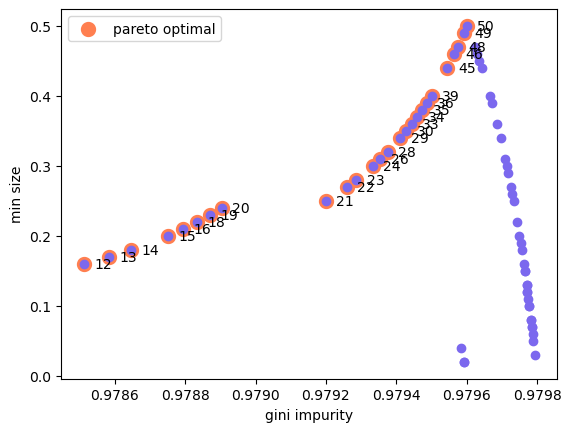

In [14]:
# Gini Impurity (pareto optimal)
mask = paretoset(pd.DataFrame({
    "ginis": ginis,
    "sizes": sizes[1:],
}), sense=["min","max"])
pdx, pdy, val = zip(*[ (g, s, v) for g, s, m, v in zip(ginis, sizes[1:], mask, sorted_attribute_values[1:]) if m ])
pareto_optimal_gini_values = val

fig, ax = plt.subplots()

ax.scatter(pdx, pdy, label="pareto optimal", color=COLORS.pareto, linewidths=5)
ax.scatter(ginis, sizes[1:], color=COLORS.gini)

for x, y, v in zip(pdx, pdy, val):
    ax.annotate(int(v), (x, y), xytext=(0.75, -0.3), textcoords="offset fontsize")

ax.legend()

plt.xlabel("gini impurity")
plt.ylabel("min size")
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.gini_pareto.png', bbox_inches='tight')

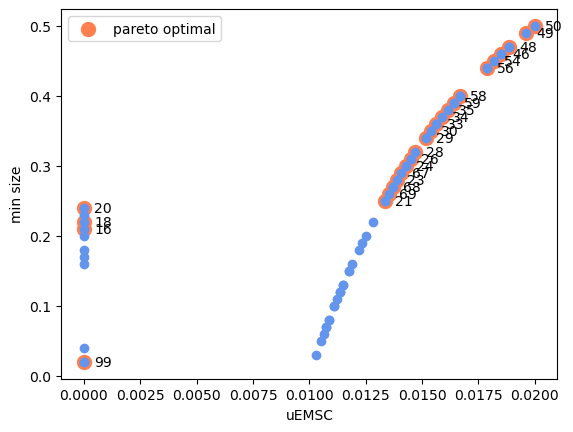

In [15]:
# Gini Impurity (pareto optimal)
mask = paretoset(pd.DataFrame({
    "uemscs": uemscs,
    "sizes": sizes[1:],
}), sense=["min","max"])
pdx, pdy, val = zip(*[ (e, s, v) for e, s, m, v in zip(uemscs, sizes[1:], mask, sorted_attribute_values[1:]) if m ])
pareto_optimal_uemsc_values = val

fig, ax = plt.subplots()

ax.scatter(pdx, pdy, label="pareto optimal", color=COLORS.pareto, linewidths=5)
ax.scatter(uemscs, sizes[1:], color=COLORS.uemsc)

for x, y, v in zip(pdx, pdy, val):
    ax.annotate(int(v), (x, y), xytext=(0.75, -0.3), textcoords="offset fontsize")

ax.legend()

plt.xlabel("uEMSC")
plt.ylabel("min size")
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.uemsc_pareto.png', bbox_inches='tight')

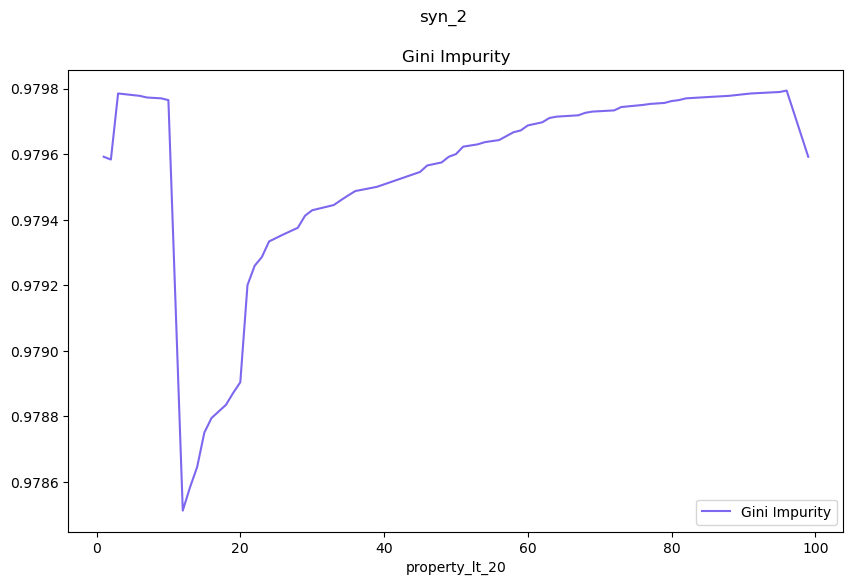

In [16]:
# Gini Impurity
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], ginis, label="Gini Impurity", color=COLORS.gini)
plt.suptitle(file_name)
plt.title("Gini Impurity")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.gini.png', bbox_inches='tight')

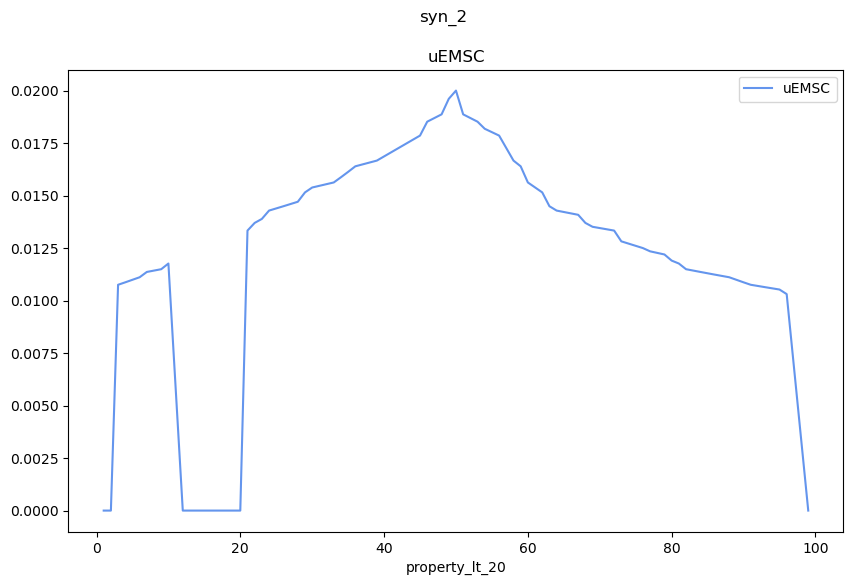

In [17]:
# uEMSC
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], uemscs, label="uEMSC", color=COLORS.uemsc)
plt.suptitle(file_name)
plt.title("uEMSC")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.uemsc.png', bbox_inches='tight')

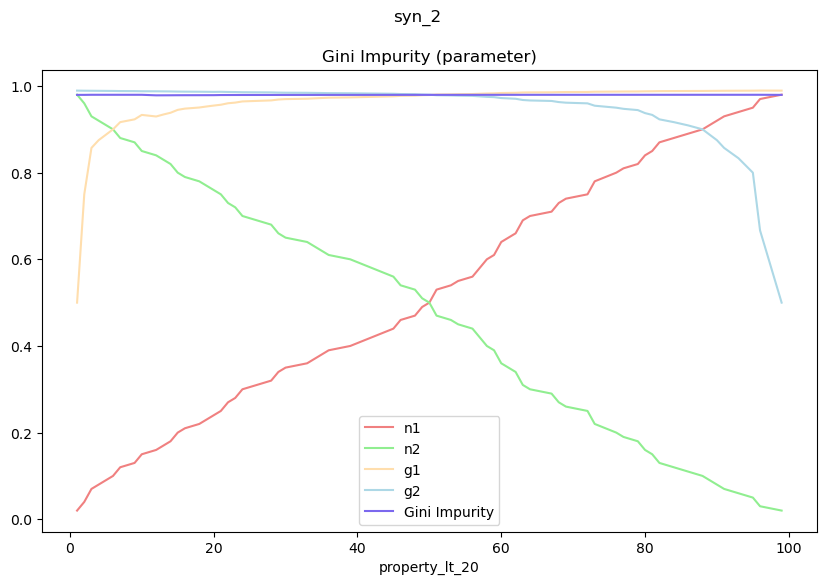

In [18]:
# Gini Impurity (parameter)
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], n1s, label="n1", color=COLORS.n1)
plt.plot(sorted_attribute_values[1:], n2s, label="n2", color=COLORS.n2)
plt.plot(sorted_attribute_values[1:], g1s, label="g1", color=COLORS.g1)
plt.plot(sorted_attribute_values[1:], g2s, label="g2", color=COLORS.g2)
plt.plot(sorted_attribute_values[1:], ginis, label="Gini Impurity", color=COLORS.gini)
plt.suptitle(file_name)
plt.title("Gini Impurity (parameter)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.gini_parameter.png', bbox_inches='tight')

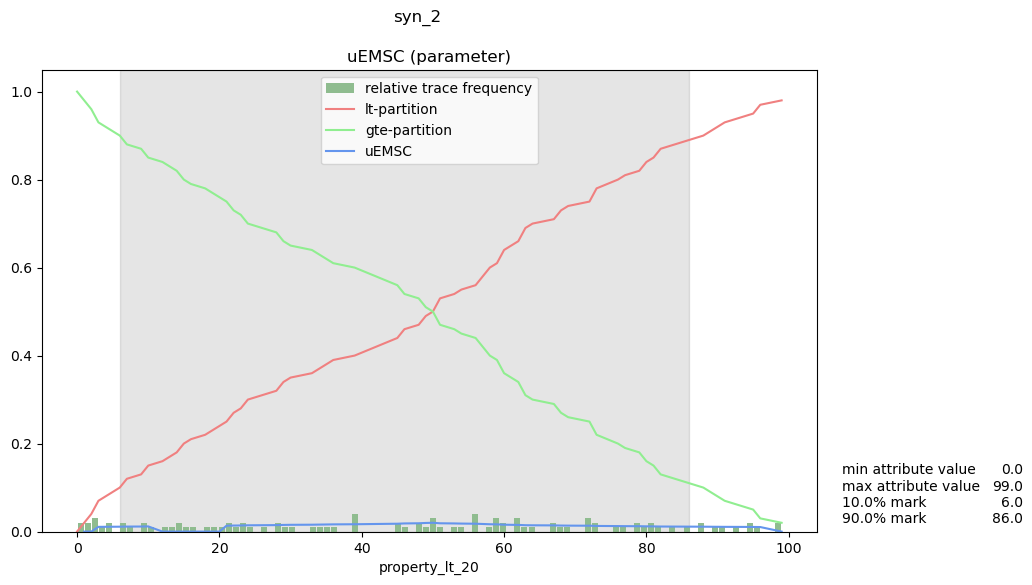

In [19]:
# uEMSC (parameter)
plt.figure(figsize=(10,6))
plt.axvspan(sorted_attribute_values[bounds_idx["lower"]], sorted_attribute_values[bounds_idx["upper"]], color='black', alpha=0.1)
plt.hist(sorted_attribute_values, bins=100, weights=rel_freq, rwidth=0.85, label="relative trace frequency", color=COLORS.rel_freq)
plt.plot(sorted_attribute_values, rel_lt_sizes, label="lt-partition", color=COLORS.lt)
plt.plot(sorted_attribute_values, rel_gte_sizes, label="gte-partition", color=COLORS.gte)
plt.plot(sorted_attribute_values[1:], uemscs, label="uEMSC", color=COLORS.uemsc)
plt.figtext(0.925, .125, "\n".join(["min attribute value", "max attribute value", f'{alpha * 100}% mark', f'{(1 - alpha) * 100}% mark']), {'multialignment': 'left'})
plt.figtext(1.075, .125, "\n".join([f'{sorted_attribute_values[0]}', f'{sorted_attribute_values[-1]}', f'{sorted_attribute_values[bounds_idx["lower"]]}', f'{sorted_attribute_values[bounds_idx["upper"]]}']), {'multialignment': 'right'})
plt.suptitle(file_name)
plt.title("uEMSC (parameter)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.uemsc_parameter.png', bbox_inches='tight')

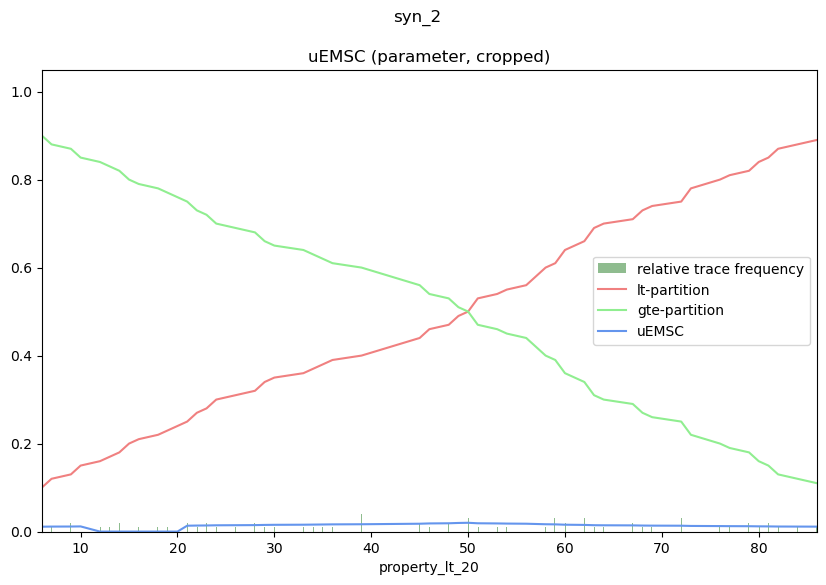

In [20]:
# uEMSC (parameter, cropped)
plt.figure(figsize=(10,6))
plt.hist(sorted_attribute_values, bins=1000, weights=rel_freq, rwidth=0.85, label="relative trace frequency", color=COLORS.rel_freq)
plt.plot(sorted_attribute_values, rel_lt_sizes, label="lt-partition", color=COLORS.lt)
plt.plot(sorted_attribute_values, rel_gte_sizes, label="gte-partition", color=COLORS.gte)
plt.plot(sorted_attribute_values[1:], uemscs, label="uEMSC", color=COLORS.uemsc)
plt.axis(xmin=sorted_attribute_values[bounds_idx["lower"]], xmax=sorted_attribute_values[bounds_idx["upper"]])
plt.suptitle(file_name)
plt.title("uEMSC (parameter, cropped)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.uemsc_parameter_cropped.png', bbox_inches='tight')

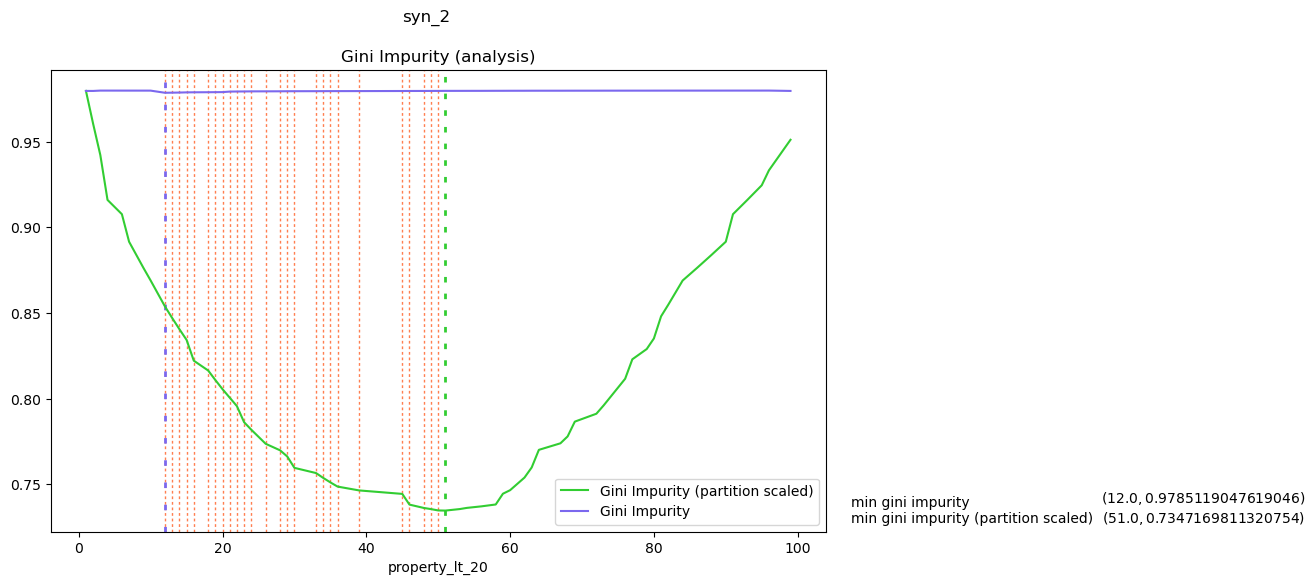

In [21]:
# Gini Impurity (analysis)
plt.figure(figsize=(10,6))

for v in pareto_optimal_gini_values:
    plt.axvline(x=v, color=COLORS.pareto, linewidth=1, linestyle="dashed", dashes=(2,2))

plt.axvline(x=sorted_attribute_values[1:][min_partition_scaled_gini_idx], color=COLORS.partition_scaled, linewidth=2, linestyle="dashed", dashes=(2,4))
plt.axvline(x=sorted_attribute_values[1:][min_gini_idx], color=COLORS.gini, linewidth=2, linestyle="dashed", dashes=(2,6))

plt.plot(sorted_attribute_values[1:], partition_scaled_gini, label="Gini Impurity (partition scaled)", color=COLORS.partition_scaled)
plt.plot(sorted_attribute_values[1:], ginis, label="Gini Impurity", color=COLORS.gini)

plt.figtext(0.925, .125, "\n".join(["min gini impurity", "min gini impurity (partition scaled)"]), {'multialignment': 'left'})
plt.figtext(1.175, .125, "\n".join([f'(${sorted_attribute_values[1:][min_gini_idx]}, ${min_gini})', f'(${sorted_attribute_values[1:][min_partition_scaled_gini_idx]}, ${min_partition_scaled_gini})']), {'multialignment': 'right'})
plt.suptitle(file_name)
plt.title("Gini Impurity (analysis)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.gini_analysis.png', bbox_inches='tight')

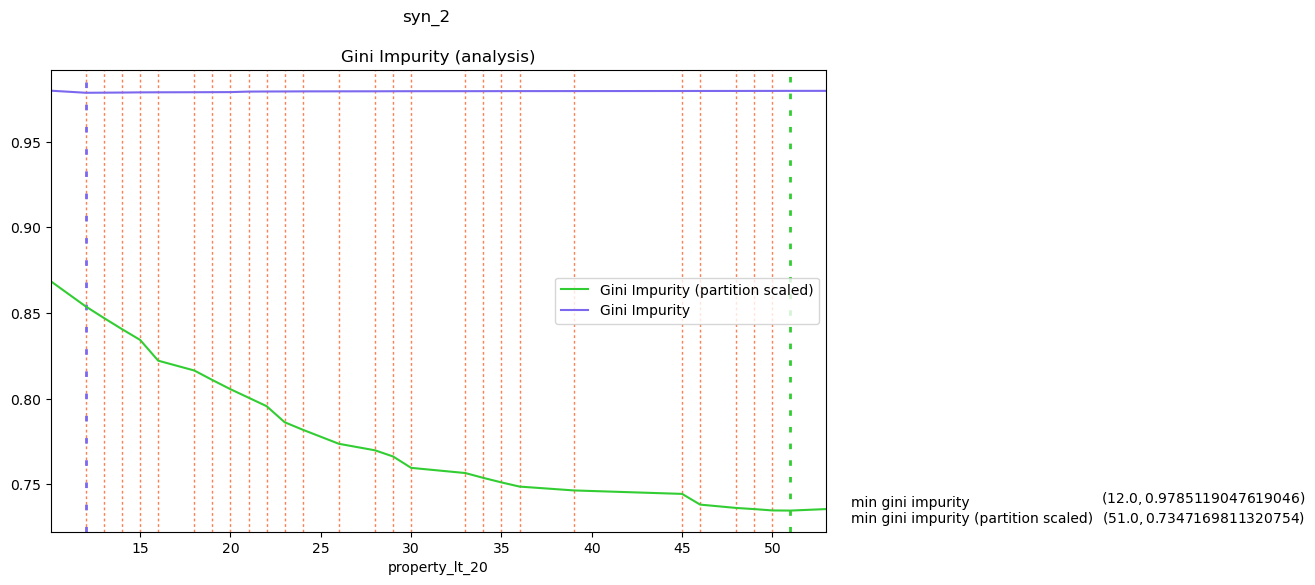

In [22]:
# Gini Impurity (analysis, cropped)
plt.figure(figsize=(10,6))

for v in pareto_optimal_gini_values:
    plt.axvline(x=v, color=COLORS.pareto, linewidth=1, linestyle="dashed", dashes=(2,2))

plt.axvline(x=sorted_attribute_values[1:][min_partition_scaled_gini_idx], color=COLORS.partition_scaled, linewidth=2, linestyle="dashed", dashes=(2,4))
plt.axvline(x=sorted_attribute_values[1:][min_gini_idx], color=COLORS.gini, linewidth=2, linestyle="dashed", dashes=(2,6))

plt.plot(sorted_attribute_values[1:], partition_scaled_gini, label="Gini Impurity (partition scaled)", color=COLORS.partition_scaled)
plt.plot(sorted_attribute_values[1:], ginis, label="Gini Impurity", color=COLORS.gini)

plt.figtext(0.925, .125, "\n".join(["min gini impurity", "min gini impurity (partition scaled)"]), {'multialignment': 'left'})
plt.figtext(1.175, .125, "\n".join([f'(${sorted_attribute_values[1:][min_gini_idx]}, ${min_gini})', f'(${sorted_attribute_values[1:][min_partition_scaled_gini_idx]}, ${min_partition_scaled_gini})']), {'multialignment': 'right'})

xs = list(pareto_optimal_gini_values) + [sorted_attribute_values[1:][min_gini_idx], sorted_attribute_values[1:][min_partition_scaled_gini_idx]]
pad = 0.05 * (max(xs) - min(xs))
plt.axis(xmin=min(xs) - pad, xmax=max(xs) + pad)

plt.suptitle(file_name)
plt.title("Gini Impurity (analysis)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.gini_analysis.png', bbox_inches='tight')

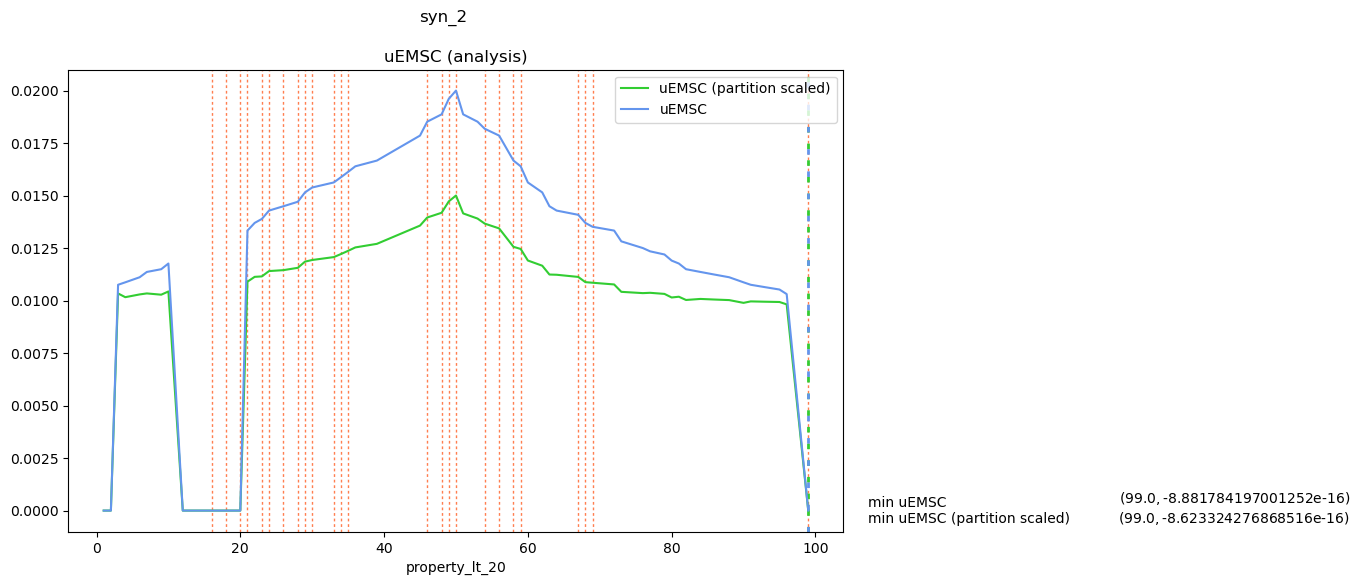

In [23]:
# uEMSC (analysis)
plt.figure(figsize=(10,6))

for v in pareto_optimal_uemsc_values:
    plt.axvline(x=v, color=COLORS.pareto, linewidth=1, linestyle="dashed", dashes=(2,2))

plt.axvline(x=sorted_attribute_values[1:][min_partition_scaled_uemsc_idx], color=COLORS.partition_scaled, linewidth=2, linestyle="dashed", dashes=(2,4))
plt.axvline(x=sorted_attribute_values[1:][min_uemsc_idx], color=COLORS.uemsc, linewidth=2, linestyle="dashed", dashes=(2,6))

plt.plot(sorted_attribute_values[1:], partition_scaled_uemsc, label="uEMSC (partition scaled)", color=COLORS.partition_scaled)
plt.plot(sorted_attribute_values[1:], uemscs, label="uEMSC", color=COLORS.uemsc)

plt.figtext(0.925, .125, "\n".join(["min uEMSC", "min uEMSC (partition scaled)"]), {'multialignment': 'left'})
plt.figtext(1.175, .125, "\n".join([f'(${sorted_attribute_values[1:][min_uemsc_idx]}, ${min_uemsc})', f'(${sorted_attribute_values[1:][min_partition_scaled_uemsc_idx]}, ${min_partition_scaled_uemsc})']), {'multialignment': 'right'})
plt.suptitle(file_name)
plt.title("uEMSC (analysis)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.uemsc_analysis.png', bbox_inches='tight')

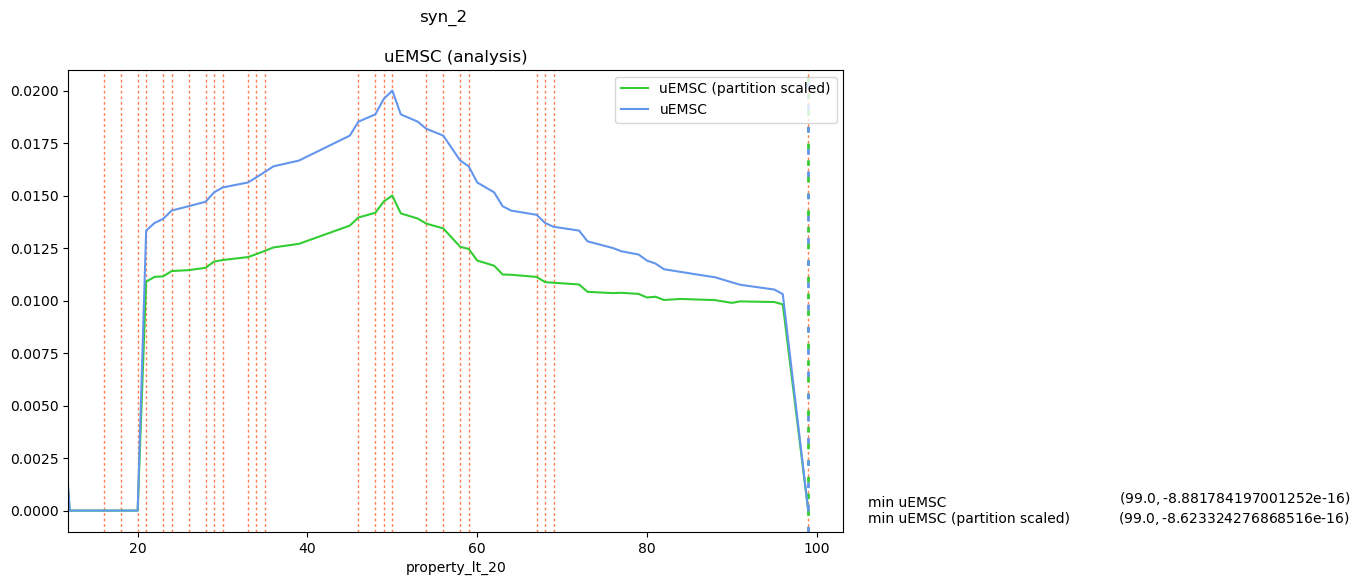

In [24]:
# uEMSC (analysis, cropped)
plt.figure(figsize=(10,6))

for v in pareto_optimal_uemsc_values:
    plt.axvline(x=v, color=COLORS.pareto, linewidth=1, linestyle="dashed", dashes=(2,2))

plt.axvline(x=sorted_attribute_values[1:][min_partition_scaled_uemsc_idx], color=COLORS.partition_scaled, linewidth=2, linestyle="dashed", dashes=(2,4))
plt.axvline(x=sorted_attribute_values[1:][min_uemsc_idx], color=COLORS.uemsc, linewidth=2, linestyle="dashed", dashes=(2,6))

plt.plot(sorted_attribute_values[1:], partition_scaled_uemsc, label="uEMSC (partition scaled)", color=COLORS.partition_scaled)
plt.plot(sorted_attribute_values[1:], uemscs, label="uEMSC", color=COLORS.uemsc)

plt.figtext(0.925, .125, "\n".join(["min uEMSC", "min uEMSC (partition scaled)"]), {'multialignment': 'left'})
plt.figtext(1.175, .125, "\n".join([f'(${sorted_attribute_values[1:][min_uemsc_idx]}, ${min_uemsc})', f'(${sorted_attribute_values[1:][min_partition_scaled_uemsc_idx]}, ${min_partition_scaled_uemsc})']), {'multialignment': 'right'})

xs = list(pareto_optimal_uemsc_values) + [sorted_attribute_values[1:][min_uemsc_idx], sorted_attribute_values[1:][min_partition_scaled_uemsc_idx]]
pad = 0.05 * (max(xs) - min(xs))
plt.axis(xmin=min(xs) - pad, xmax=max(xs) + pad)

plt.suptitle(file_name)
plt.title("uEMSC (analysis)")
plt.xlabel(attribute_key)
plt.legend()
plt.savefig(f'graphs/{version}/{file_name}.{attribute_key}.uemsc_analysis.png', bbox_inches='tight')